In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.1.dev320+g92a6eb9f4 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset , Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints
from gammapy.estimators import  FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

#sys.path.append(
#    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
#)
#from my_dataset_maps_20 import MapDatasetNuisance
#from MapDatasetNuisanceE import MapDatasetNuisanceE
#from  my_fit_20 import Fit
from Dataset_Creation import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : UK8R1wl6 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model ty

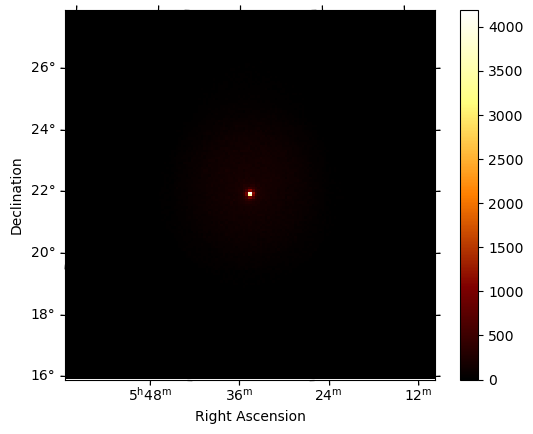

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_standard = dataset_standard.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models

dataset_asimov = dataset_standard.copy()
dataset_asimov.counts = dataset_standard.npred()
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_standard)

## Varying the Exposure

In [4]:
savefig = False
picformat = 'svg'
shift = 0.01
tilt = 0.015


In [5]:
infos = np.loadtxt("data/7a_P_draw_info.txt")
pars = np.loadtxt("data/7a_P_draw_par.txt")
flux = np.loadtxt("data/7a_P_draw_flux.txt")
flux2e = np.loadtxt("data/7a_P_draw_flux2e.txt")


lem = len(infos)
N_max = 1000
N = np.min([lem, N_max])

print(N)

shift_rnds = infos[:N_max,0]
index_rnds = infos[:N_max,1]
stat_sums = infos[:N_max,2]


#amplitude', 'index', 'norm', 'tilt
amplitudes = pars[:N_max,0:2] 
indices = pars[:N_max,2:4] 
norms = pars[:N_max,4:6]
tilts = pars[:N_max,6:8]


fluxpoints = []
for f in shift_rnds:
    try:
        print(f'6_fluxpoints_{f:.6}')
        ff = FluxPoints.read(f'data/fluxpoints/6_fluxpoints_{f:.6}.fits') 
        fluxpoints.append(ff)
        
    except:
        pass
print(len(fluxpoints), len(shift_rnds))    
N = len(fluxpoints)

11
6_fluxpoints_-0.0252148
6_fluxpoints_0.0894835
6_fluxpoints_0.15488
6_fluxpoints_-0.0790496
6_fluxpoints_-0.0211832
6_fluxpoints_-0.00792549
6_fluxpoints_-0.244064
6_fluxpoints_0.196801
6_fluxpoints_0.0621196
6_fluxpoints_0.134875
6_fluxpoints_0.000796347
10 11


In [6]:
sys_ = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = 0, 
                        tilt = 0,
                        rnd = False)
dataset_asimov = sys_.create_dataset()
dataset_asimov_N = sys_.create_dataset_N()
zero = 1e-24
## addional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
np.fill_diagonal(penalising_invcovmatrix,
                 [1/shift**2, 1/tilt**2, 1/zero**2, 1/zero**2])
dataset_asimov_N.penalising_invcovmatrix = penalising_invcovmatrix


fit_cor = Fit(store_trace=False)
result_cor = fit_cor.run([dataset_asimov])    
result_cor = fit_cor.run([dataset_asimov_N])


In [7]:
dataset_asimov_N.models[-1].parameters['norm_nuisance'].frozen = True
dataset_asimov_N.models[-1].parameters['tilt_nuisance'].frozen = True

In [8]:
mask = dataset_asimov.mask.data[:,60,60]
ebins = dataset_asimov.counts.geom.axes[0].center[mask]
energy_bounds = (ebins[0] , ebins[-1] ) *u.TeV

(-0.2661077403072091, 0.2661077403072091)

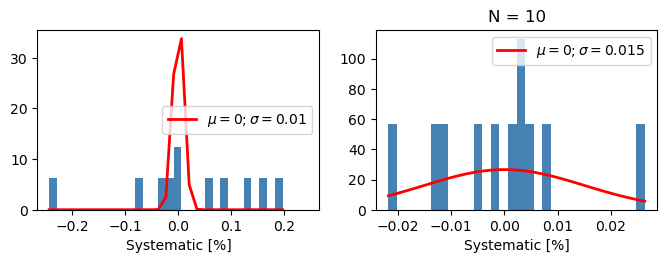

In [9]:
fig, (axs, ax1) = plt.subplots(1,2, figsize = (2*4,7/3))
nbins = 30
count, bins, ignored = axs.hist(shift_rnds, nbins, density=True, color = 'steelblue')
sigma =shift
mu = 0
axs.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r', label = f'$\mu = {mu}; \sigma = {sigma}$')

axs.set_xlabel("Systematic [%]")
axs.legend()

x = axs.get_xlim()
deltax = np.max([ mu - x[0] , x[1] - mu ])
axs.set_xlim(mu -deltax, 
                mu + deltax)


count, bins, ignored = ax1.hist(index_rnds, nbins, density=True, color = 'steelblue')
sigma =tilt
mu = 0
ax1.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r', label = f'$\mu = {mu}; \sigma = {sigma:.3}$')

ax1.set_xlabel("Systematic [%]")
ax1.set_title(f"N = {N}")
ax1.legend()

x = axs.get_xlim()
deltax = np.max([ mu - x[0] , x[1] - mu ])
axs.set_xlim(mu -deltax, 
                mu + deltax)



## Compute Asimov Fluxpoints

does not work because of the is_norm in the model

In [10]:
fluxpoints_asimov_N = FluxPoints.read("data/6_fluxpoints_asimov_N.fits")
fluxpoints_asimov = FluxPoints.read("data/6_fluxpoints_asimov.fits")


In [11]:
energy_edges = dataset_asimov.geoms['geom'].axes[0].edges

In [12]:
def plot_shifted (ff, shift):
    return ff.energy_ref* shift, ff.e2dnde.data[:,0,0],  ff.e2dnde_err.data[:,0,0], 

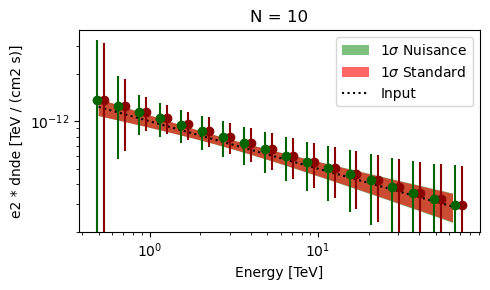

In [13]:
fig, axs = plt.subplots(1,1, figsize = (5,3))
dataset_asimov_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Nuisance", facecolor = "green", alpha = 0.5)    
    
dataset_asimov.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Standard", facecolor = "red", alpha = 0.6)

dataset_standard.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = 2, ax = axs,
                                label = "Input", color = "black", )




e_, f_, ferr_ = plot_shifted(fluxpoints_asimov, 1.1)
axs.errorbar(e_, f_, yerr = ferr_, color = 'darkred', fmt='o')  

e_, f_, ferr_ = plot_shifted(fluxpoints_asimov_N, 1.)
axs.errorbar(e_, f_, yerr = ferr_, color = 'darkgreen', fmt='o')  


axs.legend()
axs.set_title(f"N = {N}")
plt.tight_layout()


In [14]:
mask2 = fluxpoints[0].ts.data[:,0,0].data > 4
mask2

fluxpoints[0].ts.data[:,0,0].mask = mask2

In [15]:

e2dnde = []

for f in fluxpoints:
    mask2 = f.ts.data[:,0,0].data > 4
    e2dnde.append(f.e2dnde.data[:,0,0])
e2dnde = np.array(e2dnde)   



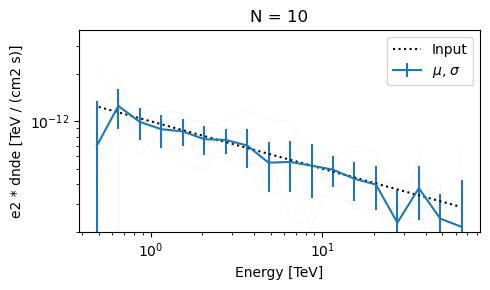

In [16]:
fig, axs1 = plt.subplots(1,1,figsize = (5,3) )
for f,e  in zip(fluxpoints,e2dnde):
    axs1.plot(f.energy_ref* 1.0, e    , color = 'black', alpha = 0.01)
    
axs1.errorbar(f.energy_ref, e2dnde.mean(axis = 0), yerr = e2dnde.std(axis=0) , 
              label = "$\mu$, $\sigma$"
            )

dataset_standard.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = 2, ax = axs1,
                                label = "Input", color = "black", )
ylim = axs.get_ylim()
axs1.set_ylim(ylim[0], ylim[1])
axs1.loglog()
axs1.set_title(f"N = {N}")
axs1.legend()
plt.tight_layout()

if savefig:
    fig.savefig(f"plots/7d_fluxpoints_rnd_{shift}_{N}." + picformat)


In [17]:
def fraction_within_e(lower_lim, upper_lim, data):
    withine = []
    for ie in range(len(lower_lim)):
        xs = []
        for f in data:
            value = f[ie]   
            lowerlim = (np.all(value >= lower_lim[ie]))
            upperlim = (np.all(value <= upper_lim[ie]))
            x = lowerlim & upperlim
            xs.append(x)
        withine.append(np.count_nonzero(xs) / len(data))
    withine  = np.array(withine)
    return withine[withine>0] 

In [18]:
e_, f_, ferr_ = plot_shifted(fluxpoints_asimov, 1.05)
within_e = fraction_within_e(f_-ferr_ , f_ + ferr_, e2dnde)

e_, f_, ferr_ = plot_shifted(fluxpoints_asimov_N, 1.05)
within_eN = fraction_within_e(f_-ferr_ , f_ + ferr_, e2dnde)
within_eN


array([1. , 0.9, 0.7, 0.7, 0.8, 0.7, 0.9, 0.6, 0.5, 0.7, 0.7, 1. , 0.9,
       0.8, 0.6, 0.8, 0.9, 0.6])

In [19]:
def compute_precision(N):
    Z = 1.645
    return  Z / np.sqrt(N)
p = compute_precision(N)

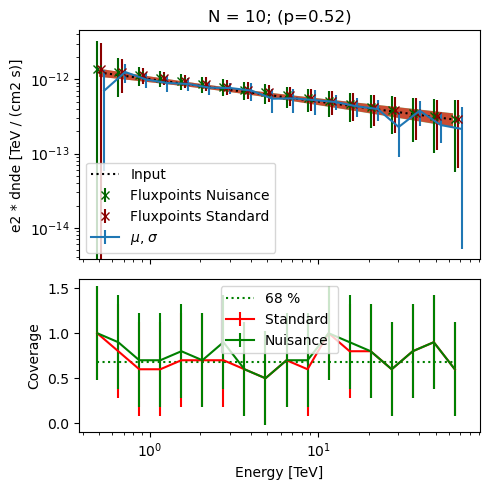

In [20]:
fig, (axs, ax2) = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 2]},
                         sharex = True, figsize = ((5,5)))

dataset_asimov_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "", facecolor = "green", alpha = 0.5)    
    
dataset_asimov.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "", facecolor = "red", alpha = 0.6)

dataset_standard.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = 2, ax = axs,
                                label = "Input", color = "black", )

e_, f_, ferr_ = plot_shifted(fluxpoints_asimov_N, 1.)
axs.errorbar(e_, f_, yerr = ferr_, color = 'darkgreen', fmt='x', label = "Fluxpoints Nuisance")  

e_, f_, ferr_ = plot_shifted(fluxpoints_asimov, 1.05)
axs.errorbar(e_, f_, yerr = ferr_, color = 'darkred', fmt='x', label = "Fluxpoints Standard")  



axs.errorbar(f.energy_ref* 1.1, e2dnde.mean(axis = 0), yerr = e2dnde.std(axis=0) , 
                 label = "$\mu$, $\sigma$")


ax2.errorbar(ebins, within_e, yerr=p,color = 'red', label = f"Standard ")
ax2.errorbar(ebins, within_eN,yerr=p, color = 'green', label = "Nuisance")
ax2.plot(ebins, [0.68] * len(ebins), ':', color = 'green', label = "68 %")

axs.set_xlabel('')
axs.legend()
ax2.legend()
axs.set_title(f"N = {N}; (p={p:.2})")
ax2.set_xlabel('Energy [TeV]')
ax2.set_ylabel('Coverage')

axs.set_xlabel('')
axs.legend()

plt.tight_layout()
if savefig:
    fig.savefig(f"plots/7d_fluxpoints_coverage_{shift}_{N}." + picformat)
